In [1]:



import gc
import os

import numpy as np
import pandas as pd
import networkx as nx

from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

DATA_PATH = '../../data/'

gc.collect()


0

In [2]:


# get opponent team id
def get_opponent_team_id(data):
    
    opps = data.copy()[['game_id','team_id']].drop_duplicates().reset_index(drop=True)
    opps['team_AorB'] = opps.groupby(['game_id'])['team_id'].rank('dense').astype(int).map({
        1:'A',
        2:'B'
    })
    opps = opps.pivot(index='game_id', columns=['team_AorB'], values='team_id').reset_index()
    opps.columns=['game_id','team_id','opp_id']
    opps2 = opps.copy()
    opps2.columns=['game_id','opp_id','team_id']
    opps = pd.concat([opps, opps2], axis=0).dropna().reset_index(drop=True)
    opps['team_id'] = opps['team_id'].astype(int)
    opps['opp_id'] = opps['opp_id'].astype(int)
    
    return opps



In [3]:



def get_possessions(pbox_data):
    
    opponent_ids = get_opponent_team_id(pbox_data.copy())
    ## estimate number of possessions from box score 
    poss = pbox_data.groupby(['game_id','team_id'])[['fga','to','fta','oreb']].sum().reset_index()
    ## commonly used possession estimate formula
    ## (FGA – OR) + TO + (0.44 * FTA)
    poss['tm_poss'] = (poss['fga'].copy()-poss['oreb'].copy())+poss['to'].copy()+(0.44*poss['fta'].copy())
    poss = poss.drop(columns=['fga','to','fta','oreb'])

    possession_key = opponent_ids.copy().merge(poss, how='left', on=['game_id','team_id'])
    poss = poss.rename(columns={'team_id':'opp_id','tm_poss':'opp_poss'})
    possession_key = possession_key.copy().merge(poss, how='left', on=['game_id','opp_id'])
    possession_key['game_possessions'] = possession_key[['tm_poss','opp_poss']].copy().mean(axis=1)
    possession_key = possession_key.drop(columns=['tm_poss','opp_poss','opp_id'])

    return possession_key.sort_values(by='game_id').reset_index(drop=True)

def add_player_boxscore_features(data):
    
    #pbox
    data['fgm'] = data['fg'].apply(lambda x: x.split('-')[0])
    data['fga'] = data['fg'].apply(lambda x: x.split('-')[-1])
    data['fg3m'] = data['fg3'].apply(lambda x: x.split('-')[0])
    data['fg3a'] = data['fg3'].apply(lambda x: x.split('-')[-1])
    data['ftm'] = data['ft'].apply(lambda x: x.split('-')[0])
    data['fta'] = data['ft'].apply(lambda x: x.split('-')[-1])

    data['fgm']= data['fgm'].replace('',0)
    data['fgm'] = data['fgm'].astype(int)
    data['fga']= data['fga'].replace('',0)
    data['fga'] = data['fga'].astype(int)
    data['ftm']= data['ftm'].replace('',0)
    data['ftm'] = data['ftm'].astype(int)
    data['fta']= data['fta'].replace('',0)
    data['fta'] = data['fta'].astype(int)
    
    data['oreb']= data['oreb'].replace('',0)
    data['oreb'] = data['oreb'].astype(int)
    data['dreb']= data['dreb'].replace('',0)
    data['dreb'] = data['dreb'].astype(int)
    data['reb']= data['reb'].replace('',0)
    data['reb'] = data['reb'].astype(int)

    data['fg3m']= data['fg3m'].replace('',0)
    data['fg3m'] = data['fg3m'].astype(int)
    data['fg3a']= data['fg3a'].replace('',0)
    data['fg3a'] = data['fg3a'].astype(int)

    data['fg2m'] = data['fgm'].copy()-data['fg3m'].copy()
    data['fg2a'] = data['fga'].copy()-data['fg3a'].copy()
    
    possess = get_possessions(data.copy())
    data = data.merge(possess, how='left', on=['game_id','team_id'])

    data['fg%'] = (data['fgm'].copy()/data['fga'].copy()).fillna(0)
    data['fg2%'] = (data['fg2m'].copy()/data['fg2a'].copy()).fillna(0)
    data['fg3%'] = (data['fg3m'].copy()/data['fg3a'].copy()).fillna(0)

    data['eFG%'] = ((data['fgm'].copy()+(data['fg3m'].copy()*0.5))/data['fga'].copy()).fillna(0)
    data['TS%'] = ((data['pts'].copy())/(2*(data['fga'].copy()+(0.44*data['fta'].copy())))).fillna(0)
    # pbox[['fg','fg3m','fga']].dtypes
    data['pts_pm'] = data['pts'].copy()/data['min'].copy()
    data['reb_pm'] = data['reb'].copy()/data['min'].copy()
    data['ast_pm'] = data['ast'].copy()/data['min'].copy()
    data['stl_pm'] = data['stl'].copy()/data['min'].copy()
    data['blk_pm'] = data['blk'].copy()/data['min'].copy()
    data['to_pm'] = data['to'].copy()/data['min'].copy()
    data['pf_pm'] = data['pf'].copy()/data['min'].copy()
    
    ## could be improved with OT markers
    ## percentage of estimated possessions player took part of
    data['player_possessions'] = data['game_possessions'].copy()*(data['min'].copy()/(40*2)) # times 2 because game possessions = 
    
    data['pts_pp'] = data['pts'].copy()/data['player_possessions'].copy()
    data['reb_pp'] = data['reb'].copy()/data['player_possessions'].copy()
    data['ast_pp'] = data['ast'].copy()/data['player_possessions'].copy()
    data['stl_pp'] = data['stl'].copy()/data['player_possessions'].copy()
    data['blk_pp'] = data['blk'].copy()/data['player_possessions'].copy()
    data['to_pp'] = data['to'].copy()/data['player_possessions'].copy()
    data['pf_pp'] = data['pf'].copy()/data['player_possessions'].copy()
    
    return data


def clean_player_boxscores(data):
    for stat_col in ['min','pts','oreb','dreb','reb','ast','stl','blk','to','pf']:
        data[stat_col] = data[stat_col].replace('--',0)
        data[stat_col] = data[stat_col].astype(int)

    return data


def load_player_boxscore_season(year):
    return add_player_boxscore_features(\
            clean_player_boxscores(\
            pd.read_csv(os.path.join(DATA_PATH, f'ESPN/player_boxscores/{year}.csv'))))

pbox = load_player_boxscore_season(2022)
opponent_ids = get_opponent_team_id(pbox.copy())


/var/folders/6j/0sqk1ykn5f10xfsflg6djktr0000gn/T/ipykernel_80703/3756916011.py:99: DtypeWarning: Columns (6,7,8,9,10,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  pbox = load_player_boxscore_season(2022)


In [4]:


def create_graph(graph_data):
    
    
    p2p1 = graph_data.copy().loc[graph_data['p2p1']==1].reset_index(drop=True)
    p1p2 = graph_data.copy().loc[graph_data['p2p1']==0].reset_index(drop=True)

    nodes = list(set(list(graph_data.player_1_id.unique())+list(graph_data.player_2_id.unique())))
#     print(f"There are {len(nodes)} players")

    p2p1 = p2p1[['player_2_id','player_1_id','edge_weight']]
    p1p2 = p1p2[['player_1_id','player_2_id','edge_weight']]
    p2p1.columns=['sender','receiver','edge_weight']
    p1p2.columns=['sender','receiver','edge_weight']

    edges = pd.concat([p2p1, p1p2], axis=0).reset_index(drop=True)
    edges = [tuple([e[0], e[1], e[2]]) for e in edges.values]
    
#     print(f"There are {np.round(len(edges)/len(nodes))} observations per player, on average")
    
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_weighted_edges_from(edges)
    
    return G


def get_pagerank(net, stat, min_threshold=5):
    
    net = net.copy().loc[net['min']>=min_threshold].reset_index(drop=True)
    
    net = net[['game_id','team_id','athlete_id',stat,'min']]
    net['team_order'] = net.copy().groupby(['game_id'])['team_id'].rank('dense').astype(int).map({
        1:'A',
        2:'B'
    })
    net['player_order'] = net.copy().groupby(['game_id','team_id'])['min'].rank('dense').astype(int)
    # re rank after cutoff
    net = net.sort_values(by=['game_id','team_id','min'], ascending=[True, True, False])
    net['player_order'] = net.copy().groupby(['game_id','team_id'])['min'].rank('first',ascending=False).astype(int)
    net = net.loc[net['player_order']<=8].reset_index(drop=True)
    net['player_team_id'] = net['team_order'].astype(str) + '-' +net['player_order'].astype(str)
    
    net = net.pivot(index='game_id', columns='player_team_id', values=['athlete_id',stat]).reset_index()
    
    net_data = []
    for player_1 in [f'A-{i}' for i in range(1, 9)]:
        for player_2 in [f'B-{i}' for i in range(1, 9)]:
            matchup = pd.concat([net['athlete_id'][[player_1, player_2]], net[stat][[player_1, player_2]]], axis=1)
            matchup.columns=['player_1_id','player_2_id','player_1_pts','player_2_pts']
            net_data.append(matchup)

    net_data = pd.concat(net_data)
    
    net_data = net_data.dropna().reset_index(drop=True)
    net_data['player_1_id'] = net_data['player_1_id'].astype(int)
    net_data['player_2_id'] = net_data['player_2_id'].astype(int)

    # if ppm equal, no blood (no link)
    net_data['to_drop'] = np.where(net_data['player_1_pts']==net_data['player_2_pts'], 1, 0)
    net_data = net_data.loc[net_data['to_drop']==0].reset_index(drop=True)
    net_data = net_data.drop(columns=['to_drop'])
    net_data['p2p1'] = np.where(net_data['player_1_pts']>net_data['player_2_pts'],1,0)
    net_data['edge_weight'] = (net_data['player_1_pts'] - net_data['player_2_pts']).abs() 
    
    graph = create_graph(net_data.copy())
    
    prnk = nx.pagerank(graph)
    prnk = pd.Series(prnk).reset_index()
    
    prnk.columns=['player_id', f'{stat}_prnk']
    
    # standardize by degree
    degrees = pd.DataFrame.from_dict(graph.degree())
    degrees.columns=['player_id','degree']
    prnk = prnk.copy().merge(degrees, how='left', on='player_id')
    prnk[f'{stat}_norm_prnk'] = 100000* (prnk[f'{stat}_prnk'].copy()/prnk['degree'].copy())
    prnk = prnk.sort_values(by=f'{stat}_norm_prnk', ascending=False)
    
    prnk = prnk.loc[prnk['degree']>20]  # minimum 100 opponent players played (~12-15 games)
    
    return prnk.sort_values(by=[f'{stat}_norm_prnk'], ascending=False).drop(columns=['degree']).reset_index(drop=True)


stat_ = 'pts_pm'
tmp_prnk = get_pagerank(pbox, stat_)



In [5]:


## create name mapping
players_id2name = pbox.copy().drop_duplicates(subset=['athlete_id'])[['athlete_id','athlete_display_name']].set_index('athlete_id').to_dict()['athlete_display_name']
players_name2id = {v:k for k,v in players_id2name.items()}

players_id2team = pbox.copy().drop_duplicates(subset=['athlete_id'],keep='last')[['athlete_id','team_short_display_name']].set_index('athlete_id').to_dict()['team_short_display_name']

teams_id2name = pbox.copy().drop_duplicates(subset=['team_id'])[['team_id','team_short_display_name']].set_index('team_id').to_dict()['team_short_display_name']
teams_name2id = {v:k for k,v in teams_id2name.items()}

stat_ = 'pts_pm'
tmp_prnk = get_pagerank(pbox, stat_)
tmp_prnk = tmp_prnk.sort_values(by='pts_pm_norm_prnk',ascending=False)
tmp_prnk['player_name'] = tmp_prnk['player_id'].map(players_id2name)
tmp_prnk['player_team'] = tmp_prnk['player_id'].map(players_id2team)
tmp_prnk.head(20)



,player_id,pts_pm_prnk,pts_pm_norm_prnk,player_name,player_team
0,4597867,0.000206,0.858678,Keeshawn Kellman,Princeton
1,4433192,0.001588,0.786194,Tari Eason,LSU
2,4600663,0.001557,0.778658,Zach Edey,Purdue
3,4594327,0.001635,0.733235,Keegan Murray,Iowa
4,4432638,0.000704,0.697176,Daeshun Ruffin,Ole Miss
5,4432828,0.001328,0.688172,Kofi Cockburn,Illinois
6,4431719,0.000341,0.609109,Khalif Battle,Temple
7,4432854,0.000454,0.589851,Kalib Boone,Oklahoma State
8,4432356,0.001071,0.575690,Johnny Davis,Wisconsin
9,4432879,0.001087,0.563250,Isiaih Mosley,Missouri State


In [6]:


player_ranks = []
stats = ['eFG%','TS%','pts_pm','reb_pm','ast_pm','stl_pm','blk_pm','to_pm','pf_pm']
for season in [2007,2008,2009,2010,2011,2012,2013,2014,2015, 2016,2017, 2018, 2019, 2020, 2021, 2022]:
    season_player_rank = None
    for stat_ in tqdm(stats):

        pbox = load_player_boxscore_season(season)

        # get ids
        teams_id2name = pbox.copy().drop_duplicates(subset=['team_id'])[['team_id','team_short_display_name']].set_index('team_id').to_dict()['team_short_display_name']
        teams_name2id = {v:k for k,v in teams_id2name.items()}
        players_id2name = pbox.copy().drop_duplicates(subset=['athlete_id'])[['athlete_id','athlete_display_name']].set_index('athlete_id').to_dict()['athlete_display_name']
        players_name2id = {v:k for k,v in teams_id2name.items()}
        
        players_id2team = pbox.copy().drop_duplicates(subset=['athlete_id'], keep='last')[['athlete_id','athlete_display_name']].set_index('athlete_id').to_dict()['athlete_display_name']
        
        tmp_prnk = get_pagerank(pbox, stat_)
        if season_player_rank is None:
            season_player_rank = tmp_prnk.copy()
        else:
            season_player_rank = season_player_rank.merge(tmp_prnk, how='left', on='player_id')

    season_player_rank['season']=season
    season_player_rank['player_name'] = season_player_rank['player_id'].map(players_id2name) + f'_{season}'
    season_player_rank['player_team'] = season_player_rank['player_id'].map(players_id2team)
    player_ranks.append(season_player_rank)

player_ranks = pd.concat(player_ranks).sort_values(by='pts_pm_norm_prnk', ascending=False).reset_index(drop=True)




  0%|                                                                                                                              | 0/9 [00:00<?, ?it/s]/var/folders/6j/0sqk1ykn5f10xfsflg6djktr0000gn/T/ipykernel_80703/2290608886.py:7: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  pbox = load_player_boxscore_season(season)
  0%|                                                                                                                              | 0/9 [00:00<?, ?it/s]/var/folders/6j/0sqk1ykn5f10xfsflg6djktr0000gn/T/ipykernel_80703/2290608886.py:7: DtypeWarning: Columns (6,7,8,9,10,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  pbox = load_player_boxscore_season(season)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:01<00:00,  6.79s/it]


In [7]:

player_ranks.head()


,player_id,eFG%_prnk,eFG%_norm_prnk,TS%_prnk,TS%_norm_prnk,pts_pm_prnk,pts_pm_norm_prnk,reb_pm_prnk,reb_pm_norm_prnk,ast_pm_prnk,...,stl_pm_norm_prnk,blk_pm_prnk,blk_pm_norm_prnk,to_pm_prnk,to_pm_norm_prnk,pf_pm_prnk,pf_pm_norm_prnk,season,player_name,player_team
0,27614,0.000173,0.822823,0.000184,0.800242,0.000372,1.617106,0.000072,0.311904,NaN,...,NaN,NaN,NaN,0.000074,0.350995,0.000113,0.492644,2008,James Tchana_2008,James Tchana
1,54283,0.000075,0.313995,0.000087,0.362952,0.000293,1.221059,0.000083,0.347177,0.000061,...,NaN,NaN,NaN,0.000068,0.285366,0.000050,0.206492,2013,DeAndre Haskins_2013,DeAndre Haskins
2,4279823,0.000185,0.463230,0.000184,0.458761,0.000431,1.076994,0.000033,0.082780,0.000023,...,NaN,0.000039,0.183538,0.000066,0.184208,0.000061,0.169440,2018,John Grant Jr._2018,John Grant Jr.
3,4701559,0.000134,0.462132,0.000136,0.452531,0.000300,1.072225,0.000200,0.691214,0.000117,...,NaN,NaN,NaN,NaN,NaN,0.000130,0.498744,2021,Collin Holloway_2021,Collin Holloway
4,45966,0.000223,0.475220,0.000227,0.453098,0.000531,1.061584,0.000087,0.174902,0.000042,...,0.126478,NaN,NaN,0.000099,0.230957,0.000134,0.263122,2010,Deniz Kilicli_2010,Deniz Kilicli


In [8]:

player_ranks.to_csv('./output/player_components.csv', index=False)


In [15]:

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

stat_cols = [s + '_prnk' for s in stats]

pca_X = player_ranks.copy()
for pc_col in stat_cols:
    pca_X[pc_col] = pca_X[pc_col].fillna(pca_X[pc_col].median())
pca_X = pca_X[stat_cols]
ss = StandardScaler()
pca_X = ss.fit_transform(pca_X)
pca = PCA(n_components=2)

pca_cols = pca.fit_transform(pca_X)
pca_df = pd.DataFrame(pca_cols, columns=['pc_1','pc2'])

test = player_ranks.copy()
test[['pc_1','pc_2']] = pca_df


test = test.dropna().reset_index(drop=True)


In [16]:



poys = ['Anthony Davis_2012','Trey Burke_2013','Doug McDermott_2014','Frank Kaminsky_2015','Buddy Hield_2016','Frank Mason III_2017','Jalen Brunson_2018','Zion Williamson_2019','Obi Toppin_2020','Luka Garza_2021','Oscar Tshiebwe_2022']

kpoys = ['Draymond Green_2012','Russ Smith_2013','Russ Smith_2014','Frank Kaminsky_2015','Brice Johnson_2016','Josh Hart_2017','Trae Young_2018','Jarrett Culver_2019,','Luka Garza_2020','Drew Timme_2021']

test['is_poy'] = np.where(test['player_name'].copy().isin(poys+kpoys), 1, 0)

poys = test.copy().loc[test['is_poy']==1].reset_index(drop=True)
npoys = test.copy().loc[test['is_poy']==0].sample(frac=1).reset_index(drop=True)



In [17]:

test.loc[test['player_name'].str.contains('Russ Smith')]


,player_id,eFG%_prnk,eFG%_norm_prnk,TS%_prnk,TS%_norm_prnk,pts_pm_prnk,pts_pm_norm_prnk,reb_pm_prnk,reb_pm_norm_prnk,ast_pm_prnk,...,to_pm_prnk,to_pm_norm_prnk,pf_pm_prnk,pf_pm_norm_prnk,season,player_name,player_team,pc_1,pc_2,is_poy
88,51478,0.000299,0.141071,0.000295,0.136172,0.001421,0.673382,0.000220,0.099883,0.000998,...,0.000488,0.234444,0.000380,0.180133,2012,Russ Smith_2012,Russ Smith,6.240508,-5.212254,0
108,51478,0.000393,0.161123,0.000486,0.201543,0.001473,0.643421,0.000289,0.131509,0.000841,...,0.000292,0.125252,0.000179,0.076569,2013,Russ Smith_2013,Russ Smith,5.407493,-3.695855,1
681,51478,0.000398,0.188611,0.000377,0.176977,0.000936,0.467887,0.000130,0.059431,0.001453,...,0.000336,0.148460,0.000194,0.089837,2014,Russ Smith_2014,Russ Smith,4.635094,-5.073585,1


In [18]:

test.season.value_counts()



2022    3517
2019    3437
2017    3416
2015    3415
2014    3407
2016    3401
2018    3394
2020    3390
2013    3320
2010    3317
2011    3300
2009    3288
2008    3256
2012    3253
2021    3178
2007    3146
Name: season, dtype: int64

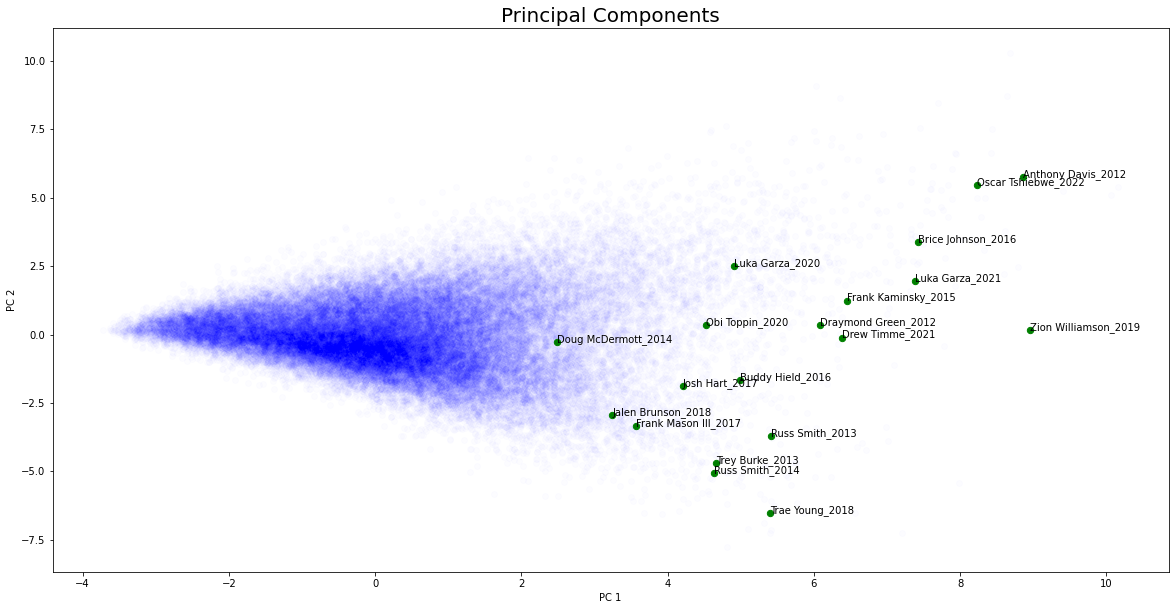

In [23]:


import matplotlib.pyplot as plt


fig, ax=plt.subplots(figsize=(20, 10))

plt.scatter(npoys.pc_1, npoys.pc_2, c='b', alpha = 0.01)
plt.scatter(poys.pc_1, poys.pc_2, c='g', s=40)

plt.title("Principal Components", fontsize=20)


for i in range(poys.shape[0]):
    plt.text(x=poys.pc_1[i],y=poys.pc_2[i],s=poys.player_name[i])

ax.set_ylabel('PC 2')
ax.set_xlabel('PC 1')

plt.show()



# test.loc[test['player_name'].str.contains('III_2017')]



In [20]:

test.sort_values(by='pc_1', ascending=False).head(60)


,player_id,eFG%_prnk,eFG%_norm_prnk,TS%_prnk,TS%_norm_prnk,pts_pm_prnk,pts_pm_norm_prnk,reb_pm_prnk,reb_pm_norm_prnk,ast_pm_prnk,...,to_pm_prnk,to_pm_norm_prnk,pf_pm_prnk,pf_pm_norm_prnk,season,player_name,player_team,pc_1,pc_2,is_poy
63,45882,0.000528,0.233417,0.000514,0.221544,0.001634,0.704293,0.002507,1.119270,0.000282,...,0.000369,0.160497,0.000430,0.187715,2010,DeMarcus Cousins_2010,DeMarcus Cousins,10.156531,5.393134,0
361,36578,0.000650,0.316862,0.000679,0.326267,0.001054,0.527152,0.003204,1.609839,0.000155,...,0.000180,0.092853,0.000299,0.144453,2009,DeJuan Blair_2009,DeJuan Blair,10.062113,5.111974,0
11485,31711,0.000786,0.365546,0.000764,0.348709,0.000473,0.218148,0.002636,1.286060,0.000439,...,0.000299,0.142191,0.000686,0.329864,2010,Brian Zoubek_2010,Brian Zoubek,9.404861,5.253856,0
6,4395628,0.000628,0.306399,0.000681,0.329192,0.001766,0.874069,0.001189,0.588427,0.000459,...,0.000186,0.090520,0.000104,0.051683,2019,Zion Williamson_2019,Zion Williamson,8.959193,0.160949,1
1487,56353,0.000708,0.318950,0.000723,0.316899,0.000916,0.399943,0.001291,0.589447,0.000174,...,0.000140,0.066858,0.000139,0.060477,2012,Anthony Davis_2012,Anthony Davis,8.861083,5.758795,1
218,44654,0.000701,0.315635,0.000708,0.307791,0.001310,0.572259,0.001617,0.738364,0.000606,...,0.000329,0.149565,0.000321,0.147773,2011,Markieff Morris_2011,Markieff Morris,8.786279,2.460373,0
4296,32037,0.000560,0.246563,0.000615,0.263768,0.000710,0.307194,0.001198,0.518519,0.000142,...,0.000259,0.113083,0.000241,0.102028,2009,Jarvis Varnado_2009,Jarvis Varnado,8.676115,10.294525,0
3595,32037,0.000646,0.256535,0.000673,0.259988,0.000806,0.323822,0.001008,0.411524,0.000126,...,0.000268,0.109197,0.000253,0.101112,2010,Jarvis Varnado_2010,Jarvis Varnado,8.638362,8.707393,0
123,31786,0.000517,0.239309,0.000537,0.242943,0.001434,0.626043,0.001454,0.661127,0.000210,...,0.000257,0.118499,0.000663,0.295821,2007,Darrell Arthur_2007,Darrell Arthur,8.615989,3.780891,0
2,36671,0.000504,0.224996,0.000573,0.252570,0.002048,0.989235,0.001660,0.809717,0.000179,...,0.000329,0.146382,0.000159,0.072306,2008,Michael Beasley_2008,Michael Beasley,8.593331,2.222337,0
